In [7]:
import json, requests, sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [158]:
#import csv of all cards and their reprints for later training
#cards_df = pandas.read_csv("./cards/cards.csv", dtype = "str")
#list(cards_df)
#cards_df = cards_df[["name", "manaCost", "types", "subtypes", "text"]].fillna('')

#Use mtgjson's online versions as they are updated weekly
def createDataframe(url):
    df = pd.read_csv(url, storage_options = {'User-Agent': 'Mozilla/5.0'}, low_memory = False)
    return df
    
cards_df = createDataframe("https://mtgjson.com/api/v5/csv/cards.csv")
#Remove all Un-set cards
cards_df = cards_df[~cards_df['setCode'].isin(['UGL', 'UST', 'UND', 'UNF', 'UNH'])] #Remove all Un-set cards

#Create new dataframe containing only these 7 columns for later analysis
cards = cards_df[["name", "manaCost", "manaValue", "types", "subtypes", "rarity", "power", "toughness", 'text']].fillna('').drop_duplicates()
#Remove all alchemy cards (start with A-) as they are purely rebalance
cards = cards[~cards['name'].str.contains('^A-')]
#Remove all newline characters (\n) and replace them with a space character
#cards = cards.replace(r'\\n', ' ', regex=True) 
#Write file to csv for local storage in case
cards.to_csv('./data/info.csv', sep = ',', index=False)

# Data Exploration

<Axes: xlabel='manaCost', ylabel='count'>

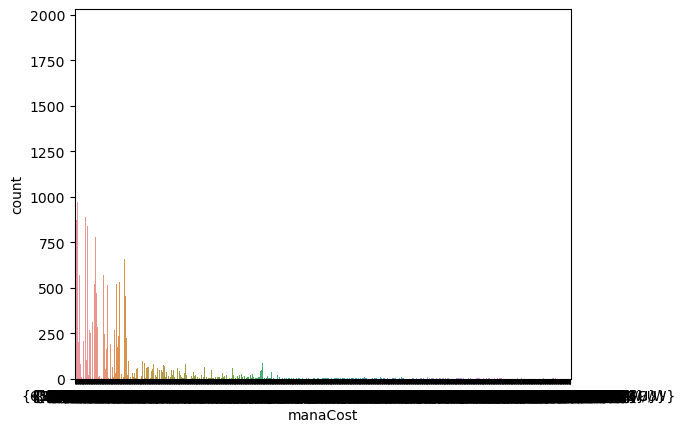

In [9]:
sns.countplot(x='manaCost',data=cards) #Need to split between colors

In [10]:
#ensure max mana values arent astronomical and delete max row if 
def printMaxRowValues(df: pd.DataFrame):
    if df['manaValue'].max() >= 20: #Drop outlier max value row if exists
        df = df.drop(df['manaValue'].idxmax())
    print(df[df['manaValue'] == df['manaValue'].max()][['name', 'manaCost', 'manaValue']].values) #show card name and associated MV

white = cards[cards['manaCost'].str.contains('{W')]
white.style.hide(axis='index')
printMaxRowValues(white)
 
blue = cards[cards['manaCost'].str.contains('{U')]
printMaxRowValues(blue)

black = cards[cards['manaCost'].str.contains('{B')]
printMaxRowValues(black)

red = cards[cards['manaCost'].str.contains('{R')]
printMaxRowValues(red)

green = cards[cards['manaCost'].str.contains('{G')]
printMaxRowValues(green)

colorless = cards[cards['manaCost'].str.contains('^[\d{}]+$')] #Only decimal numbers, '{' & '}'
printMaxRowValues(colorless)

[['Autochthon Wurm' '{10}{G}{G}{G}{W}{W}' 15.0]]
[['Blinkmoth Infusion' '{12}{U}{U}' 14.0]]
[['Shadow of Mortality' '{13}{B}{B}' 15.0]]
[['Volcanic Salvo' '{10}{R}{R}' 12.0]]
[['Earthquake Dragon' '{14}{G}' 15.0]
 ['Autochthon Wurm' '{10}{G}{G}{G}{W}{W}' 15.0]]
[['Draco' '{16}' 16.0]]


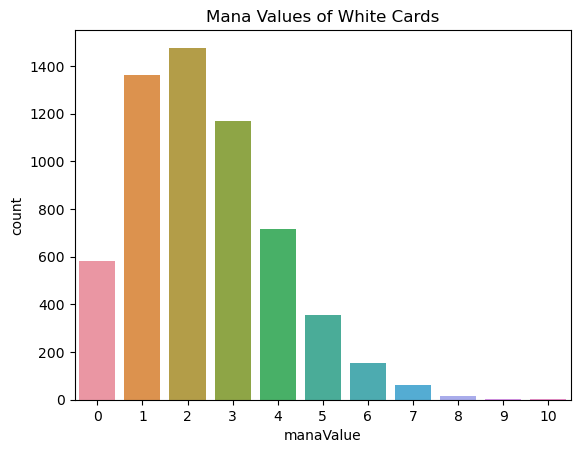

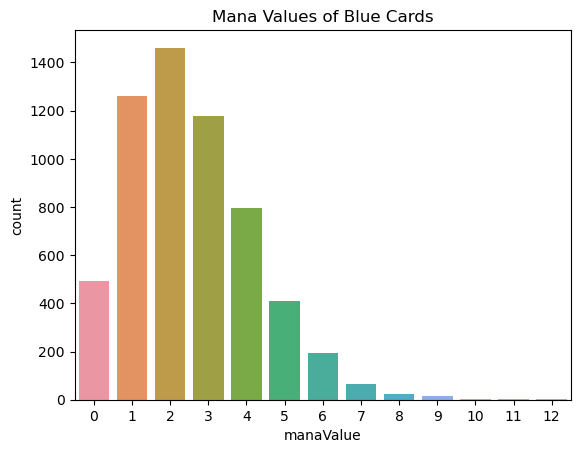

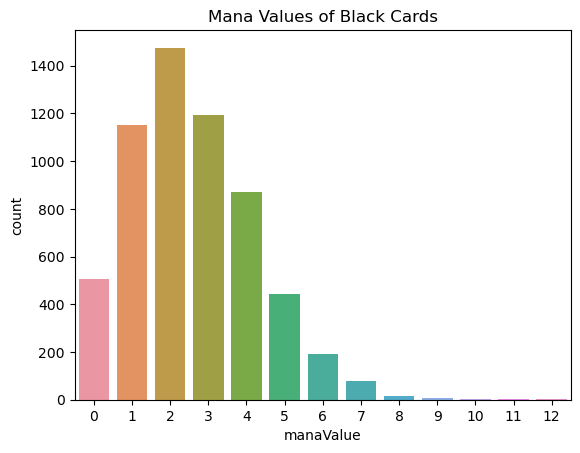

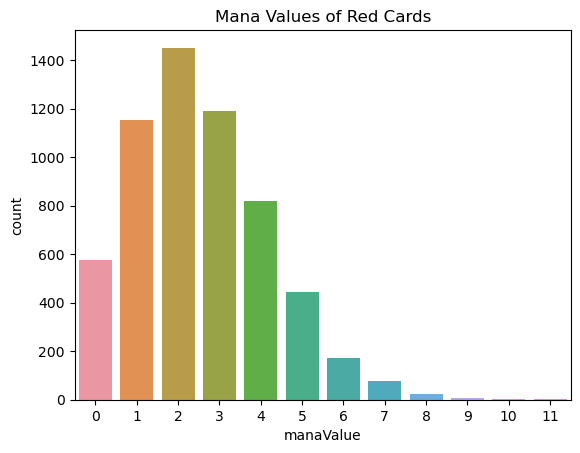

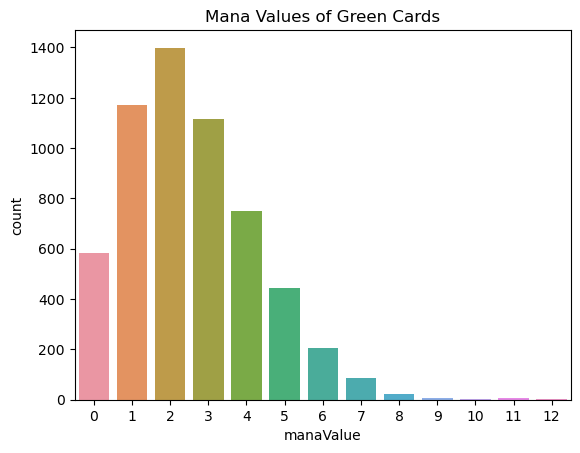

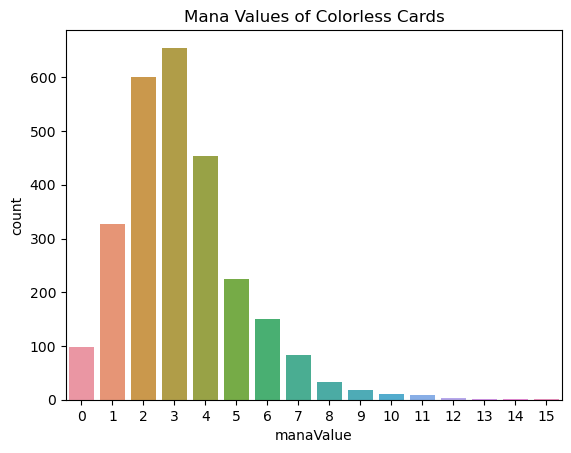

In [11]:
def plotManaValues(df: pd.DataFrame, column: str):
    ax = sns.countplot(x = column, data = df)
    xlabels = ['{:,.0f}'.format(x) for x in ax.get_xticks()] #no decimal points
    ax.set_xticklabels(xlabels)
    return ax

#White
white_plot = plotManaValues(white, 'manaValue')
white_plot.set_title('Mana Values of White Cards')
plt.show()

#Blue
blue_plot = plotManaValues(blue, 'manaValue')
blue_plot.set_title('Mana Values of Blue Cards')
plt.show()

#Black
black_plot = plotManaValues(black, 'manaValue')
black_plot.set_title('Mana Values of Black Cards')
plt.show()

#Red
red_plot = plotManaValues(red, 'manaValue')
red_plot.set_title('Mana Values of Red Cards')
plt.show()

#Green
green_plot = plotManaValues(green, 'manaValue')
green_plot.set_title('Mana Values of Green Cards')
plt.show()

#Colorless
colorless_plot = plotManaValues(colorless, 'manaValue')
colorless_plot.set_title('Mana Values of Colorless Cards')
plt.show()

# Dataset Generator

In [12]:
import tensorflow as tf
import time, os

In [13]:
text = cards.to_string(index = False, header = False, col_space = 1)
print(f'Length of text: {len(text)} characters')

Length of text: 25269771 characters


In [52]:
print(text[:10000])

,name,manaCost,manaValue,types,subtypes,rarity,power,toughness,text
0,Ancestor's Chosen,{5}{W}{W},7.0,Creature,"Human, Cleric",uncommon,4,4,First strike (This creature deals combat damag...
2,Angel of Mercy,{4}{W},5.0,Creature,Angel,uncommon,3,3,Flying\nWhen Angel of Mercy enters the battlef...
4,Angelic Blessing,{2}{W},3.0,Sorcery,,common,,,Target creature gets +3/+3 and gains flying un...
6,Angelic Chorus,{3}{W}{W},5.0,Enchantment,,rare,,,Whenever a creature enters the battlefield und...
7,Angelic Wall,{1}{W},2.0,Creature,Wall,common,0,4,Defender (This creature can't attack.)\nFlying
9,Aura of Silence,{1}{W}{W},3.0,Enchantment,,uncommon,,,Artifact and enchantment spells your opponents...
10,Aven Cloudchaser,{3}{W},4.0,Creature,"Bird, Soldier",common,2,2,Flying (This creature can't be blocked except ...
12,Ballista Squad,{3}{W},4.0,Creature,"Human, Rebel",uncommon,2,2,"{X}{W}, {T}: Ballista Squad deals X damage to ..."
13,Bandage,{W},1.0,Instant,,common,,,Prevent the next 1 damage that would be dealt ...
14,Beacon of Immortality,{5}{W},6.0,Instant,,rare,,,Double target player's life total. Shuffle Bea...


In [53]:
#save as plain text (not formatted how we want)
#np.savetxt('./cards.txt',cards.values, fmt = '%s', encoding = 'utf-8')
#cards.to_string('./cards.txt')

#For each row, output column, add ':' after, and newline for next column for later generation
cards.columns

Index(['name', 'manaCost', 'manaValue', 'types', 'subtypes', 'rarity', 'power',
       'toughness', 'text'],
      dtype='object')

In [169]:
def writeDataframeToText(filename: str, df: pd.DataFrame):
    with open(filename, "w", encoding="utf-8", newline = '\n') as f: #open a new file with filename
        for i in df.index: #for each index (row)
            if i != 0: #newlines for formatting after each row
                print('\n', file = f)
            for label, card in df.items():
                print(f'{label}: {card[i]}' , sep = '\n', file = f) #Ensure output formatted as (column name: value)
                
writeDataframeToText("cards.txt", cards) #make a new file called cards.txt from the cards dataframe

In [164]:
#Taken from rspeer's answer in https://stackoverflow.com/questions/4020539/process-escape-sequences-in-a-string-in-python
import re
import codecs

ESCAPE_SEQUENCE_RE = re.compile(r'''
    ( \\U........      # 8-digit hex escapes
    | \\u....          # 4-digit hex escapes
    | \\x..            # 2-digit hex escapes
    | \\[0-7]{1,3}     # Octal escapes
    | \\N\{[^}]+\}     # Unicode characters by name
    | \\[\\'"abfnrtv]  # Single-character escapes
    )''', re.UNICODE | re.VERBOSE)

def decode_escapes(s):
    def decode_match(match):
        return codecs.decode(match.group(0), 'unicode-escape')

    return ESCAPE_SEQUENCE_RE.sub(decode_match, s)